In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from skimage.io import imread, imread_collection

import os
from PIL import Image
import imagehash
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from tensorflow.image import rgb_to_grayscale, grayscale_to_rgb
from tensorflow.keras.models import Model
from sklearn.metrics.pairwise import cosine_similarity

# Working with Images Lab
## Information retrieval, preprocessing, and feature extraction

In this lab, you'll work with images of felines (cats), which have been classified according to their taxonomy. Each subfolder contains images of a particular species. The dataset is located [here](https://www.kaggle.com/datasets/datahmifitb/felis-taxonomy-image-classification) but it's also provided to you in the `data/` folder.

### Problem 1. Some exploration (1 point)
How many types of cats are there? How many images do we have of each? What is a typical image size? Are there any outliers in size?

In [2]:
dataset_path = "D:/Data-Science/04.Working-with-Images-Lab/data"

cat_types = [d for d in os.listdir(dataset_path)]

num_cat_types = len(cat_types)

print(f"There are {num_cat_types} types of cats in the dataset.")
print(f"Types of cats: {', '.join(cat_types)}")

There are 7 types of cats in the dataset.
Types of cats: african-wildcat, blackfoot-cat, chinese-mountain-cat, domestic-cat, european-wildcat, jungle-cat, sand-cat


In [3]:
african_wildcats = imread_collection("D:/Data-Science/04.Working-with-Images-Lab/data/african-wildcat/*")
blackfoot_cats = imread_collection("D:/Data-Science/04.Working-with-Images-Lab/data/blackfoot-cat/*")
chinese_mountain_cats = imread_collection("D:/Data-Science/04.Working-with-Images-Lab/data/chinese-mountain-cat/*")
domestic_cats = imread_collection("D:/Data-Science/04.Working-with-Images-Lab/data/domestic-cat/*")
european_wildcats = imread_collection("D:/Data-Science/04.Working-with-Images-Lab/data/european-wildcat/*")
jungle_cats = imread_collection("D:/Data-Science/04.Working-with-Images-Lab/data/jungle-cat/*")
sand_cats = imread_collection("D:/Data-Science/04.Working-with-Images-Lab/data/sand-cat/*")

In [4]:
def create_imread_collections(subfolders):
    """Creates a list of imread_collection objects for each subfolder."""
    collections = []
    for subfolder in subfolders:
        image_files = [os.path.join(subfolder, filename) 
                       for filename in os.listdir(subfolder) 
                       if filename.lower().endswith(('.jpg', '.jpeg'))]
        collection = imread_collection(image_files)
        collections.append(collection)
    return collections

main_folder = 'data' #Load the main folder
#Get a list of all subfolders
subfolders = [os.path.join(main_folder, subfolder) 
              for subfolder in os.listdir(main_folder) 
              if os.path.isdir(os.path.join(main_folder, subfolder))] 
cat_collections = create_imread_collections(subfolders)

In [5]:
print("Types of cats: " + str(len(subfolders)))
subfolders_name = [i.replace("data\\", "").replace("-", " ") for i in subfolders] #Clean the names of the subfolders
    
print(subfolders_name)
# Print out the number of images in each collection for verification
for i, collection in enumerate(cat_collections):
    print(f'{subfolders_name[i]}, Number of images: {len(collection)}')

Types of cats: 7
['african wildcat', 'blackfoot cat', 'chinese mountain cat', 'domestic cat', 'european wildcat', 'jungle cat', 'sand cat']
african wildcat, Number of images: 91
blackfoot cat, Number of images: 79
chinese mountain cat, Number of images: 42
domestic cat, Number of images: 64
european wildcat, Number of images: 85
jungle cat, Number of images: 86
sand cat, Number of images: 72


The typical image size can be defined by the average width and height of the images in each collection

In [6]:
collections = [
    african_wildcats, blackfoot_cats, chinese_mountain_cats,
    domestic_cats, european_wildcats, jungle_cats, sand_cats
]

collection_names = [
    "African Wildcats", "Blackfoot Cats", "Chinese Mountain Cats",
    "Domestic Cats", "European Wildcats", "Jungle Cats", "Sand Cats"
]

def average_image_size(image_collection):
    heights = [img.shape[0] for img in image_collection]
    widths = [img.shape[1] for img in image_collection]
    avg_height = np.mean(heights)
    avg_width = np.mean(widths)
    return avg_height, avg_width

average_sizes = {}
for name, collection in zip(collection_names, collections):
    avg_height, avg_width = average_image_size(collection)
    average_sizes[name] = (avg_height, avg_width)

for name, (avg_height, avg_width) in average_sizes.items():
    print(f"{name}: Average Height = {avg_height:.2f} px, Average Width = {avg_width:.2f} px")

African Wildcats: Average Height = 196.69 px, Average Width = 255.87 px
Blackfoot Cats: Average Height = 216.09 px, Average Width = 238.90 px
Chinese Mountain Cats: Average Height = 720.76 px, Average Width = 989.40 px
Domestic Cats: Average Height = 202.16 px, Average Width = 254.12 px
European Wildcats: Average Height = 608.94 px, Average Width = 832.87 px
Jungle Cats: Average Height = 201.20 px, Average Width = 251.71 px
Sand Cats: Average Height = 196.39 px, Average Width = 258.11 px


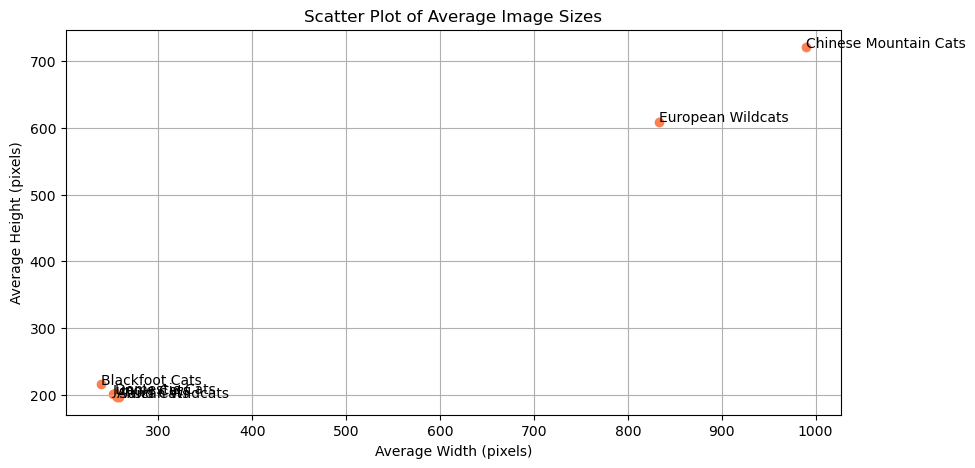

In [7]:
collection_names = list(average_sizes.keys())
avg_heights = [sizes[0] for sizes in average_sizes.values()]
avg_widths = [sizes[1] for sizes in average_sizes.values()]

plt.figure(figsize=(10, 5))
plt.scatter(avg_widths, avg_heights, color='coral')

for i, name in enumerate(collection_names):
    plt.text(avg_widths[i], avg_heights[i], name)
    
plt.title('Scatter Plot of Average Image Sizes')
plt.xlabel('Average Width (pixels)')
plt.ylabel('Average Height (pixels)')
plt.grid(True)
plt.show()

Now we can clearly see the outliers.

### Problem 2. Duplicat(e)s (1 point)
Find a way to filter out (remove) identical images. I would recommnend using file hashes, but there are many approaches. Keep in mind that during file saving, recompression, etc., a lot of artifacts can change the file content (bytes), but not visually.

In [8]:
def filter_duplicates_from_collection(collection):
    """Filters out duplicate images from the given imread_collection."""
    seen_hashes = set()
    unique_images = []
    
    for image in collection:
        # Convert image to PIL Image for hashing
        pil_image = Image.fromarray(image)
        img_hash = imagehash.average_hash(pil_image)
        
        #Add the image to the unique_images list if its hash is not in the seen_hashes set
        if img_hash not in seen_hashes:
            seen_hashes.add(img_hash)
            unique_images.append(image)
    
    return unique_images

def filter_duplicates(collections):
    """Filters duplicates from each collection and returns the list of filtered collections."""
    filtered_collections = []
    for collection in collections:
        unique_images = filter_duplicates_from_collection(collection)
        filtered_collections.append(unique_images)
    return filtered_collections

In [9]:
filtered_collections = filter_duplicates(cat_collections)

# Print out the number of unique images in each filtered collection for verification
for i, unique_images in enumerate(filtered_collections):
    print(f'{subfolders_name[i]}, Number of unique images: {len(unique_images)}')

african wildcat, Number of unique images: 89
blackfoot cat, Number of unique images: 78
chinese mountain cat, Number of unique images: 37
domestic cat, Number of unique images: 60
european wildcat, Number of unique images: 60
jungle cat, Number of unique images: 80
sand cat, Number of unique images: 70


### Problem 3. Loading a model (2 points)
Find a suitable, trained convolutional neural network classifier. I recommend `ResNet50` as it's small enough to run well on any machine and powerful enough to make reasonable predictions. Most ready-made classifiers have been trained for 1000 classes.

You'll need to install libraries and possibly tinker with configurations for this task. When you're done, display the total number of layers and the total number of parameters. For ResNet50, you should expect around 50 layers and 25M parameters.

In [10]:
model = ResNet50()

# Get the number of layers
num_layers = len(model.layers)

# Get the number of parameters
total_params = model.count_params()

print(f"Total number of layers: {num_layers}")
print(f"Total number of parameters: {total_params}")

Total number of layers: 177
Total number of parameters: 25636712


In [11]:
convulutional_layers = [layer for layer in model.layers if isinstance(layer, tf.keras.layers.Conv2D)]
print(f"Number of convolutional layers: {len(convulutional_layers)}")

Number of convolutional layers: 53


### Problem 4. Prepare the images (1 point)
You'll need to prepare the images for passing to the model. To do so, they have to be resized to the same dimensions. Most available models have a specific requirement for sizes. You may need to do additional preprocessing, depending on the model requirements. These requirements should be easily available in the model documentation.

In [12]:
def preprocess_image(image):
    image = tf.image.resize(image, [224, 224])
    image = preprocess_input(image)  # Apply ResNet50-specific preprocessing
    image = tf.expand_dims(image, axis=0)  # Add batch dimension
    return image

def process_images(filtered_collections):
    prepared_images = []
    for collection in filtered_collections:
        for img in collection:
            prepared_image = preprocess_image(img)
            prepared_images.append(prepared_image)
    return prepared_images

In [13]:
prepared_images = process_images(filtered_collections)

### Problem 5. Load the images efficiently (1 point)
Now that you've seen how to prepare the images for passing to the model... find a way to do it efficiently. Instead of loading the entire dataset in the RAM, read the images in batches (e.g. 4 images at a time). The goal is to read these, preprocess them, maybe save the preprocessed results in RAM.

If you've already done this in one of the previous problems, just skip this one. You'll get your point for it.

\* Even better, save the preprocessed image arrays (they will not be valid .jpg file) as separate files, so you can load them "lazily" in the following steps. This is a very common optimization to work with large datasets.

In [14]:
def preprocess_and_save_images(collection_list, output_dir, batch_size=4):
    # Create the output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Flatten the list of collections into a single list of images
    image_list = [image for collection in collection_list for image in collection]
    
    # Delete existing batch files in the directory
    for file_name in os.listdir(output_dir):
        if file_name.startswith('batch_') and file_name.endswith('.npy'):
            os.remove(os.path.join(output_dir, file_name))
    
    num_images = len(image_list)
    for i in range(0, num_images, batch_size):
        batch_images = image_list[i:i + batch_size]
        preprocessed_images = []

        for img in batch_images:
            img = preprocess_image(img)
            preprocessed_images.append(img)

        # Convert the list of images to a NumPy array
        image_batch = np.array(preprocessed_images)
        
        # Preprocess the batch
        preprocessed_batch = preprocess_input(image_batch)

        # Save each batch to a separate file
        batch_filename = os.path.join(output_dir, f'batch_{i // batch_size + 1}.npy')
        np.save(batch_filename, preprocessed_batch)

In [15]:
# Preprocess and save images in separate files
preprocess_and_save_images(filtered_collections, "preprocessed_batches", 5)

### Problem 6. Predictions (1 point)
Finally, you're ready to get into the meat of the problem. Obtain predictions from your model and evaluate them. This will likely involve manual work to decide how the returned classes relate to the original ones.

Create a [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix) to evaluate the classification.

In [20]:
def load_batch(file_path):
    # Load a single batch from the .npy file
    batch = np.load(file_path)
    
    # Reshape the batch if it has an extra dimension
    if batch.ndim == 5 and batch.shape[1] == 1:
        batch = np.squeeze(batch, axis=1)
    
    return batch

def make_predictions(batch):
    # Make predictions on the batch and decode predictions to readable labels
    preds = model.predict(batch)
    decoded_preds = decode_predictions(preds, top=3)  # Top-3 predictions
    
    return decoded_preds

def process_batches(directory, batch_prefix='batch_', extension='.npy', max_batches = 10):
    # List all files in the directory
    files = os.listdir(directory)
    
    # Filter files that match the batch prefix and extension
    batch_files = [f for f in files if f.startswith(batch_prefix) and f.endswith(extension)]
    
    # Limit the number of batches if max_batches is specified. This leads to only a certain count of batches to be read and displayed
    if max_batches is not None:
        batch_files = batch_files[:max_batches]
    
    #Iterate through each batch file
    for file_name in batch_files:
        file_path = os.path.join(directory, file_name)
        
        # Load the batch and make a prediction
        batch = load_batch(file_path)
        predictions = make_predictions(batch)
            
        # Print the predictions
        print(f'Predictions for {file_name}:')
        for i, preds in enumerate(predictions):
            print(f'\nImage {i + 1}:', end="")
            for label, description, score in preds:
                print(f'    {description} ({score:.2f})', end = "")

In [21]:
# Process each batch individually
process_batches("preprocessed_batches", max_batches = 5) #Here I will only display the first five batches, containing 5 images each.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step
35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
Predictions for batch_1.npy:

Image 1:    lynx (0.80)    cougar (0.18)    lion (0.01)
Image 2:    Egyptian_cat (0.90)    snow_leopard (0.03)    tabby (0.03)
Image 3:    lynx (0.38)    tiger_cat (0.35)    Egyptian_cat (0.14)
Image 4:    cougar (0.63)    hyena (0.28)    lion (0.03)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step
Predictions for batch_10.npy:

Image 1:    lynx (0.24)    llama (0.14)    hare (0.07)
Image 2:    wood_rabbit (0.24)    gazelle (0.09)    hare (0.06)
Image 3:    lynx (0.80)    leopard (0.12)    cheetah (0.04)
Image 4:    tiger_cat (0.46)    Egyptian_cat (0.24)    tiger (0.21)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step
Predictions for batch_11.npy:

Image 1:    lynx (0.85)    cougar (0.04)    tiger_cat (0.03)
Image 2:    lynx (0.52)    leopard (0.15)    prairie_chicken (0.09)
Image 3:    lynx (0.65)    Egyptian_cat (0.19)    snow_leopard (0.06)
Image 4:    lynx (0.42)    coyote (0.22)    hyena

### Problem 7. Grayscale (1 point)
Converting the images to grayscale should affect the classification negatively, as we lose some of the color information.

Find a way to preprocess the images to grayscale (using what you already have in Problem 4 and 5), pass them to the model, and compare the classification results to the previous ones.

In [23]:
grayscale_collections = [[rgb_to_grayscale(image) for image in collection] for collection in filtered_collections]
converted_collections = [[grayscale_to_rgb(image) for image in collection] for collection in grayscale_collections]

In [24]:
preprocess_and_save_images(converted_collections, "grayscale_batches", 5)

In [25]:
process_batches("grayscale_batches", max_batches = 3)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step
Predictions for batch_1.npy:

Image 1:    lynx (0.69)    cougar (0.19)    lion (0.11)
Image 2:    Egyptian_cat (0.58)    tiger_cat (0.12)    lynx (0.09)
Image 3:    tiger_cat (0.65)    tabby (0.16)    Egyptian_cat (0.13)
Image 4:    cougar (0.63)    hyena (0.28)    lion (0.03)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
Predictions for batch_10.npy:

Image 1:    zebra (0.26)    llama (0.24)    hartebeest (0.06)
Image 2:    gazelle (0.17)    hay (0.07)    lion (0.06)
Image 3:    lynx (0.40)    lion (0.29)    cheetah (0.09)
Image 4:    tiger_cat (0.52)    Egyptian_cat (0.23)    tiger (0.12)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step
Predictions for batch_11.npy:

Image 1:    lynx (0.60)    tiger_cat (0.16)    lion (0.07)
Image 2:    tiger_cat (0.28)    lynx (0.17)    leopard (0.12)
Image 3:    hyena (0.31)    Egyptian_cat (0.30)    lynx (0.08)
Image 4:    coyote (0.59)    lion (0.08)    gazelle (0.06)
Image 5:    lynx (0.49)    Egyptian_cat (0.32)    tiger_c

### Problem 8. Deep image features (1 point)
Find a way to extract one-dimensional vectors (features) for each (non-grayscale) image, using your model. This is typically done by "short-circuiting" the model output to be an intermediate layer, while keeping the input the same. 

In case the outputs (also called feature maps) have different shapes, you can flatten them in different ways. Try to not create huge vectors; the goal is to have a relatively short sequence of numbers which describes each image.

You may find a tutorial like [this](https://towardsdatascience.com/exploring-feature-extraction-with-cnns-345125cefc9a) pretty useful but note your implementation will depend on what model (and framework) you've decided to use.

It's a good idea to save these as one or more files, so you'll spare yourself a ton of preprocessing.

In [27]:
# Load ResNet50 model with weights pre-trained on ImageNet, excluding the top layer
base_model = ResNet50(weights='imagenet', include_top=False)

# Add a Global Average Pooling layer to the model
gap_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
model = Model(inputs=base_model.input, outputs=gap_layer)

# Directory containing the .npy files
batch_directory = 'preprocessed_batches'
feature_save_directory = 'extracted_features'
if os.path.exists(feature_save_directory):
    shutil.rmtree(feature_save_directory) #Clear the folder before extracting features
    
os.makedirs(feature_save_directory, exist_ok=True)

# Iterate over each .npy file in the directory
for batch_file in os.listdir(batch_directory):
    if batch_file.endswith('.npy'):
        batch_path = os.path.join(batch_directory, batch_file)
        
        # Load and preprocess the batch of images
        batch = load_batch(batch_path)
        if batch is not None:
            # Extract features from the batch
            features = model.predict(batch)
            
            # Save the extracted features to a CSV file in the specified directory
            feature_file = os.path.join(feature_save_directory, batch_file.replace('.npy', '_features.csv'))
            df = pd.DataFrame(features)
            df.to_csv(feature_file, index=False)
print("Done")

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 21s 0us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step
1/1 ━━━━━━━━━━━

### Problem 9. Putting deep image features to use (1 points)
Try to find similar images, using a similarity metric on the features you got in the previous problem. Two good metrics are `mean squared error` and `cosine similarity`. How do they work? Can you spot images that look too similar? Can you explain why?

\* If we were to take Fourier features (in a similar manner, these should be a vector of about the same length), how do they compare to the deep features; i.e., which features are better to "catch" similar images?

In [30]:
# Directory containing the extracted feature files
feature_directory = 'extracted_features'

# Load feature vectors from the CSV files
feature_files = [os.path.join(feature_directory, f) for f in os.listdir(feature_directory)]
feature_data = []
file_indices = []

for feature_file in feature_files:
    df = pd.read_csv(feature_file)
    feature_data.append(df.values)
    file_indices.extend([(os.path.basename(feature_file), idx) for idx in range(df.shape[0])])

# Combine all features into a single matrix
features = np.vstack(feature_data)

# Calculate Cosine Similarity
cos_sim_matrix = cosine_similarity(features)

# Calculate MSE for each pair of features using broadcasting
# Expanding dimensions to broadcast
features_expanded = features[:, np.newaxis, :]
mse_matrix = np.mean(np.square(features_expanded - features_expanded.transpose(1, 0, 2)), axis=2)

# Set diagonals to ignore self-comparison
np.fill_diagonal(mse_matrix, np.inf)
np.fill_diagonal(cos_sim_matrix, -np.inf)

# Flatten the matrices and get the indices of the sorted values
mse_indices = np.unravel_index(np.argsort(mse_matrix, axis=None), mse_matrix.shape)
cos_sim_indices = np.unravel_index(np.argsort(-cos_sim_matrix, axis=None), cos_sim_matrix.shape)

# Get the top 10 pairs for MSE
top_10_mse_indices = list(zip(*mse_indices))[:10]
top_10_mse = [(file_indices[i], file_indices[j], mse_matrix[i, j]) for i, j in top_10_mse_indices]
print("Top 10 similar pairs by MSE:")
for pair in top_10_mse:
    print(f"Images {pair[0][0]}[{pair[0][1]}] and {pair[1][0]}[{pair[1][1]}] have MSE: {pair[2]:.4f}")

# Get the top 10 pairs for Cosine Similarity
top_10_cos_sim_indices = list(zip(*cos_sim_indices))[:10]
top_10_cos_sim = [(file_indices[i], file_indices[j], cos_sim_matrix[i, j]) for i, j in top_10_cos_sim_indices]
print("\nTop 10 similar pairs by Cosine Similarity:")
for pair in top_10_cos_sim:
    print(f"Images {pair[0][0]}[{pair[0][1]}] and {pair[1][0]}[{pair[1][1]}] have Cosine Similarity: {pair[2]:.4f}")

Top 10 similar pairs by MSE:
Images batch_7_features.csv[2] and batch_51_features.csv[2] have MSE: 0.0004
Images batch_51_features.csv[2] and batch_7_features.csv[2] have MSE: 0.0004
Images batch_14_features.csv[1] and batch_42_features.csv[3] have MSE: 0.0008
Images batch_42_features.csv[3] and batch_14_features.csv[1] have MSE: 0.0008
Images batch_61_features.csv[4] and batch_6_features.csv[0] have MSE: 0.0076
Images batch_6_features.csv[0] and batch_61_features.csv[4] have MSE: 0.0076
Images batch_15_features.csv[1] and batch_4_features.csv[0] have MSE: 0.0100
Images batch_4_features.csv[0] and batch_15_features.csv[1] have MSE: 0.0100
Images batch_86_features.csv[0] and batch_86_features.csv[2] have MSE: 0.0170
Images batch_86_features.csv[2] and batch_86_features.csv[0] have MSE: 0.0170

Top 10 similar pairs by Cosine Similarity:
Images batch_51_features.csv[2] and batch_7_features.csv[2] have Cosine Similarity: 0.9996
Images batch_7_features.csv[2] and batch_51_features.csv[2] ha

### * Problem 10. Explore, predict, and evaluate further
You can do a ton of things here, at your desire. For example, how does masking different areas of the image affect classification - a method known as **saliency map** ([info](https://en.wikipedia.org/wiki/Saliency_map))? Can we detect objects? Can we significantly reduce the number of features (keeping the quality) that we get? Can we reliably train a model to predict our own classes? We'll look into these in detail in the future.